In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
df = pd.read_sas("c.sas7bdat")

In [66]:
variables = ['c23','c25','c28','c29_1','c29_2','niveak','region9','revenu_net','pcs','sexe','agglo','internet','age']

df = df[variables].astype('int64')


In [4]:
df

,c23,c25,c28,c29_1,c29_2,niveak,region9,revenu_net,pcs,sexe,agglo,internet,age
0,2,2,1,3,3,8,9,11,45,2,7,0,4
1,1,1,0,3,3,4,6,3,85,1,7,1,5
2,1,1,1,3,2,4,8,10,62,1,7,0,3
3,1,1,0,2,2,5,8,10,52,2,7,0,5
4,2,1,0,2,2,5,6,7,56,2,3,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3611,1,2,0,2,2,8,1,10,37,2,8,0,4
3612,1,3,1,3,3,6,9,12,47,1,1,0,4
3613,-1,1,1,2,2,6,8,1,84,2,7,0,1
3614,2,2,0,1,2,7,9,2,84,1,1,0,1


# Nettoyage des données

On remplace toutes non-réponses (-1) par des NaN afin de remplacer ces valeurs

In [67]:
for i in list(df.columns):
    df.loc[df[i]==-1,i] = np.NaN
df.interpolate('pad',inplace=True)

On remarque une mauvaise échelle pour la question c25

In [68]:
df.c25[df.c25==1] = 1
df.c25[(df.c25 == 2) | (df.c25 == 3)] = 2
df.c25[(df.c25 ==  4 )| (df.c25 == 5 )] = 3
df.c25[(df.c25 == 6) | (df.c25 == 7)] = 4
df.c25[df.c25 == 8] = 5

In [69]:
df['etude'] = 0
df.loc[(df['niveak'] == 2) | (df['niveak'] == 3) ,'etude']  = 1
df.loc[(df['niveak'] == 4)| (df['niveak'] == 5),'etude']  = 2
df.loc[(df['niveak'] == 6)| (df['niveak'] == 7),'etude'] = 3
df.loc[(df['niveak'] == 8)| (df['niveak'] == 9),'etude'] = 4

In [70]:
df['prise_risque']=df['c23'] + df['c25']
def cla(x):
    if x == 2:
        return 0
    elif x in (3,4):
        return 1
    elif x in (5,6,7):
        return 2
    elif x in (8,9):
        return 3
df.prise_risque = df.prise_risque.apply(lambda x : cla(x))

df['couvre_risque'] = round(0.40*(df['c28']+1)+(df['c29_1'])*0.30 + (df['c29_1'])*0.30)

In [9]:
a = df.prise_risque.unique()
a

array([1, 0, 2, 3], dtype=int64)

In [10]:
df.isna().describe()

,c23,c25,c28,c29_1,c29_2,niveak,region9,revenu_net,pcs,sexe,agglo,internet,age,etude,prise_risque,couvre_risque
count,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616


In [11]:
for var in ['c23','c25','c28','c29_1','c29_2','niveak','revenu_net', 'etude', 'prise_risque','couvre_risque']:
     
    cat_dtype = CategoricalDtype(
    categories=a, ordered=True)
    df[var] = df[var].astype(cat_dtype)

    


# Visualisation des données

In [13]:
df.describe(include='all')

,c23,c25,c28,c29_1,c29_2,niveak,revenu_net,etude,prise_risque,couvre_risque,internet,sexe,age
count,3616.0,3616.0,3616.0,3616.0,3616.0,3616.0,3616.0,3616.0,3616.0,3616.0,3616.000000,3616.000000,3616.000000
unique,4.0,5.0,2.0,3.0,3.0,9.0,13.0,5.0,4.0,3.0,NaN,NaN,NaN
top,1.0,1.0,0.0,3.0,3.0,4.0,6.0,2.0,0.0,2.0,NaN,NaN,NaN
freq,2521.0,2388.0,2446.0,1938.0,2071.0,944.0,505.0,1807.0,1880.0,2654.0,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.319967,1.536228,4.209071
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.466528,0.498755,1.784050
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,3.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2.000000,4.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2.000000,6.000000


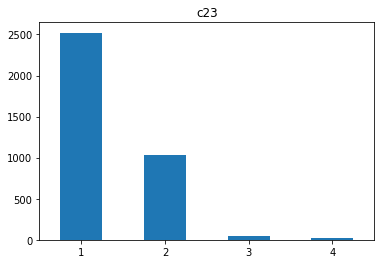

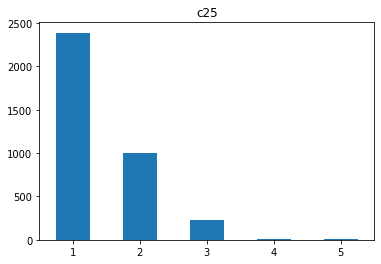

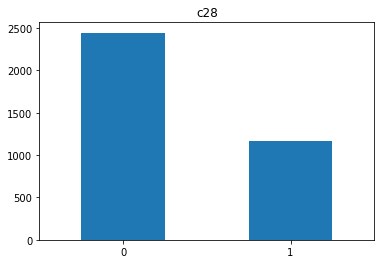

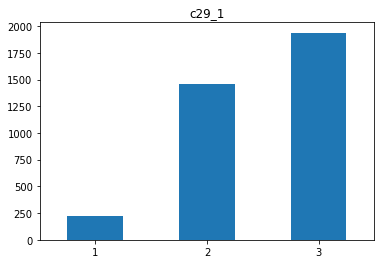

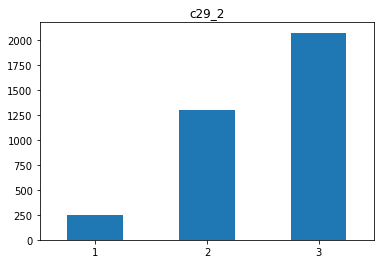

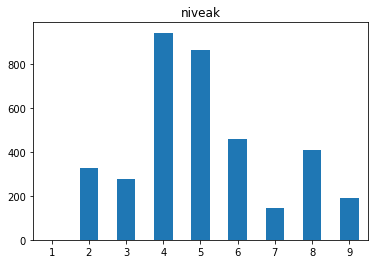

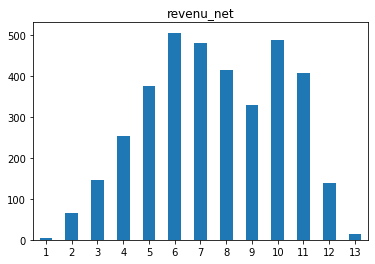

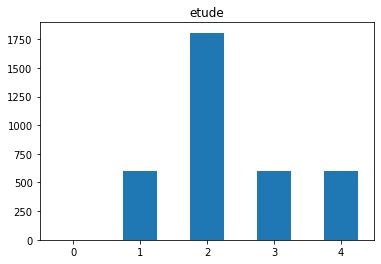

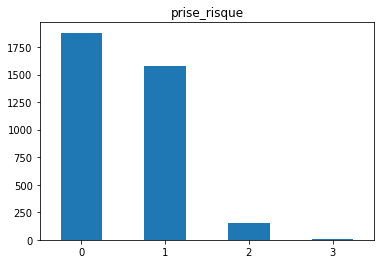

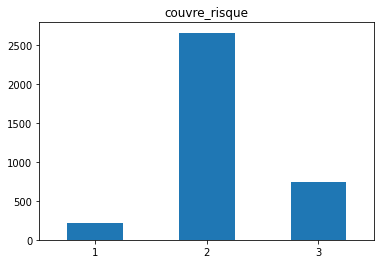

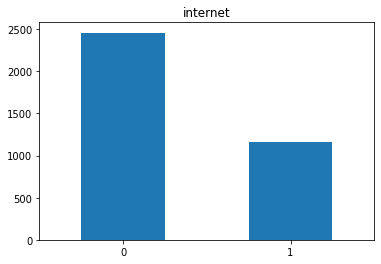

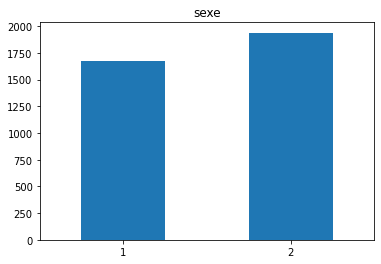

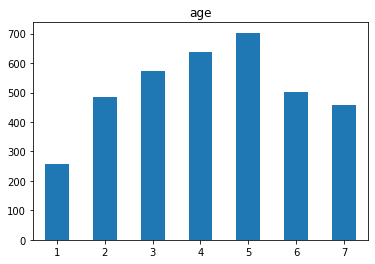

<Figure size 432x288 with 0 Axes>

In [14]:
for var in ['c23','c25','c28','c29_1','c29_2','niveak','revenu_net', 'etude', 'prise_risque','couvre_risque','internet','sexe','age'] : 
    #cat = list(df[var].unique())
    #plt.hist(df[var],range=(min(cat)-1, max(cat)),bins=len(cat),color='white',edgecolor = 'black')
    #plt.title(var)
    df[var].value_counts().sort_index().plot.bar(rot=0)
    plt.title(var)
    plt.show()
    plt.savefig(f"histo_{var}.jpg")

In [15]:
print(pd.crosstab(df['niveak'],'Nombre'))
for i in df.columns:
    print(pd.crosstab(df['niveak'],df[i]))

col_0   Nombre
niveak        
1            1
2          327
3          275
4          944
5          863
6          460
7          144
8          411
9          191
c23       1    2   3  4
niveak                 
1         1    0   0  0
2       248   72   5  2
3       217   53   3  2
4       701  221  13  9
5       614  240   7  2
6       304  150   6  0
7        96   45   3  0
8       250  154   6  1
9        90   95   6  0
c25       1    2   3  4  5
niveak                    
1         1    0   0  0  0
2       263   50  12  1  1
3       206   53  13  1  2
4       682  212  47  2  1
5       594  232  37  0  0
6       241  173  45  1  0
7        90   45   9  0  0
8       212  157  42  0  0
9        99   74  18  0  0
c28       0    1
niveak          
1         0    1
2       244   83
3       180   95
4       647  297
5       567  296
6       305  155
7        91   53
8       283  128
9       129   62
c29_1    1    2    3
niveak              
1        0    0    1
2       22  121  184
3  

In [71]:
df.corr()

,c23,c25,c28,c29_1,c29_2,niveak,region9,revenu_net,pcs,sexe,agglo,internet,age,etude,prise_risque,couvre_risque
c23,1.000000,0.258780,-0.022067,-0.072404,-0.042351,0.125145,-0.029375,0.094042,-0.086773,-0.113124,0.042646,-0.055908,-0.040010,0.123671,0.705912,-0.062086
c25,0.258780,1.000000,0.020346,-0.024400,-0.002418,0.167514,-0.016736,0.132334,-0.116840,-0.081961,0.003166,-0.091865,-0.120714,0.174317,0.764960,0.004648
c28,-0.022067,0.020346,1.000000,0.143947,0.147051,0.021050,-0.000536,-0.000163,-0.000481,0.001912,0.008769,-0.030872,-0.015447,0.011551,0.002894,0.639348
c29_1,-0.072404,-0.024400,0.143947,1.000000,0.553519,-0.013590,-0.027430,0.137188,0.005403,0.008457,-0.030924,-0.005235,0.081899,-0.009475,-0.062184,0.654922
c29_2,-0.042351,-0.002418,0.147051,0.553519,1.000000,0.000500,-0.001774,0.114762,0.001861,-0.007057,-0.031083,-0.006028,0.087142,-0.001409,-0.014311,0.413902
niveak,0.125145,0.167514,0.021050,-0.013590,0.000500,1.000000,-0.053441,0.393789,-0.401381,-0.014350,0.147672,-0.348581,-0.392920,0.965956,0.170975,0.008539
region9,-0.029375,-0.016736,-0.000536,-0.027430,-0.001774,-0.053441,1.000000,-0.084770,0.044776,0.016430,-0.232178,0.000433,-0.004701,-0.051628,-0.026003,-0.016742
revenu_net,0.094042,0.132334,-0.000163,0.137188,0.114762,0.393789,-0.084770,1.000000,-0.265759,-0.120869,0.054829,-0.371766,-0.204891,0.375855,0.135101,0.084913
pcs,-0.086773,-0.116840,-0.000481,0.005403,0.001861,-0.401381,0.044776,-0.265759,1.000000,0.117836,-0.022158,0.261444,0.344188,-0.390652,-0.122993,-0.003659
sexe,-0.113124,-0.081961,0.001912,0.008457,-0.007057,-0.014350,0.016430,-0.120869,0.117836,1.000000,0.056767,0.064893,0.025994,-0.027408,-0.115388,0.005779


In [17]:
def crosstab(x:pd.Series,y:pd.Series,pond : bool ):
  if pond == True:
    z = pd.crosstab(x,y)
    count = x.value_counts()
    for i in z.index:
      z.iloc[i-1] = z.iloc[i-1]/count.iloc[i-1]
    return z
  else :
    return pd.crosstab(x,y)



In [76]:
print(pd.crosstab(df['prise_risque'],df['etude'], margins=True, margins_name='Total'))
print(pd.crosstab(df['prise_risque'],df['age'], margins=True, margins_name='Total'))
print(pd.crosstab(df['prise_risque'],df['sexe'], margins=True, margins_name='Total'))

etude         0    1     2    3    4  Total
prise_risque                               
0             1  376  1020  257  226   1880
1             0  208   728  312  332   1580
2             0   17    57   35   44    153
3             0    1     2    0    0      3
Total         1  602  1807  604  602   3616
age           1.0  2.0  3.0  4.0  5.0  6.0  7.0  Total
prise_risque                                          
0             121  226  263  308  370  308  284   1880
1             131  242  282  290  303  174  158   1580
2               7   17   28   39   28   19   15    153
3               0    0    0    1    2    0    0      3
Total         259  485  573  638  703  501  457   3616
sexe           1.0   2.0  Total
prise_risque                   
0              776  1104   1880
1              805   775   1580
2               93    60    153
3                3     0      3
Total         1677  1939   3616


<AxesSubplot:>

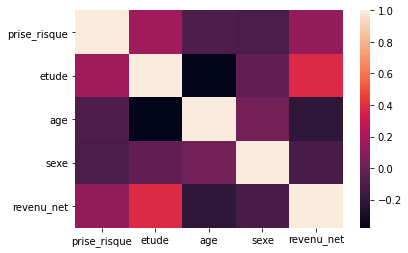

In [73]:
sns.heatmap(df[['prise_risque','etude','age','sexe','revenu_net']].corr())

# Modélisation

In [77]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [75]:
y = df[['prise_risque']]
X = df[['etude','revenu_net','sexe','age']]

mod_prob = OrderedModel(y,
                        X,
                        distr='logit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.816993
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:           prise_risque   Log-Likelihood:                -2954.2
Model:                   OrderedModel   AIC:                             5922.
Method:            Maximum Likelihood   BIC:                             5966.
Date:                Sat, 30 Apr 2022                                         
Time:                        00:15:04                                         
No. Observations:                3616                                         
Df Residuals:                    3609                                         
Df Model:                           7                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
etude          0.2912      0.041      7.186      0.000       0.212       0.371
revenu_net     0.0508      0.014      3.589      0.000       0.023       0.079
sexe          -0.4101      0.067     -6.103      0.000      -0.542      -0.278
age           -0.0454      0.020     -2.251      0.024      -0.085      -0.006
0/1            0.3237      0.202      1.605      0.109      -0.072       0.719
1/2            1.1346      0.027     42.607      0.000       1.082       1.187
2/3            1.3873      0.143      9.706      0.000       1.107       1.667
==============================================================================
"""

In [78]:
res_prob.resid_prob

array([ 0.33965578, -0.44367876, -0.55477179, ..., -0.43410442,
        0.39974739, -0.62632996])

(array([ 354., 1105.,  421.,    0.,    0.,  239.,  699.,  557.,   85.,
         156.]),
 array([-0.71988674, -0.5479629 , -0.37603907, -0.20411524, -0.03219141,
         0.13973242,  0.31165625,  0.48358008,  0.65550392,  0.82742775,
         0.99935158]),
 <BarContainer object of 10 artists>)

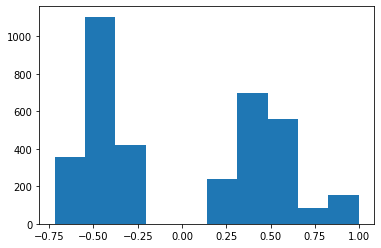

In [79]:
plt.hist(res_prob.resid_prob)

In [29]:
y = df[['couvre_risque']]
X = df[['etude','revenu_net','sexe']]

mod_prob = OrderedModel(y,
                        X,
                        distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.718183
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:          couvre_risque   Log-Likelihood:                -2596.9
Model:                   OrderedModel   AIC:                             5204.
Method:            Maximum Likelihood   BIC:                             5235.
Date:                Fri, 29 Apr 2022                                         
Time:                        22:14:08                                         
No. Observations:                3616                                         
Df Residuals:                    3611                                         
Df Model:                           5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
etude         -0.0437      0.023     -1.875      0.061      -0.089       0.002
revenu_net     0.0488      0.009      5.657      0.000       0.032       0.066
sexe           0.0442      0.041      1.074      0.283      -0.036       0.125
1/2           -1.2243      0.101    -12.161      0.000      -1.422      -1.027
2/3            0.8705      0.016     53.963      0.000       0.839       0.902
==============================================================================
"""

(array([3.31895492e-01, 0.00000000e+00, 0.00000000e+00, 7.65912673e-02,
        3.86560632e+00, 4.35518971e-02, 0.00000000e+00, 0.00000000e+00,
        1.50178956e-03, 1.11132427e+00]),
 array([-0.96495517, -0.78080908, -0.59666299, -0.4125169 , -0.22837081,
        -0.04422473,  0.13992136,  0.32406745,  0.50821354,  0.69235963,
         0.87650572]),
 <BarContainer object of 10 artists>)

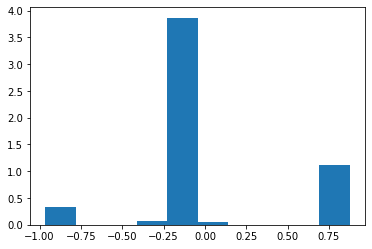

In [30]:
plt.hist(res_prob.resid_prob, density=True)